In [1]:
get_ipython().system('pip install hurst fbprophet matplotlib yfinance numpy statsmodels datetime pandas_market_calendars')


In [2]:


import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import datetime
from datetime import timedelta
from datetime import date
import pandas_ta as ta
import statsmodels.tsa.stattools as ts
from hurst import compute_Hc
from fbprophet import Prophet
import pandas_market_calendars as mcal
from finta import TA

import os.path
from os import path

from scipy.stats import ttest_ind
from numpy import cumsum

import concurrent.futures
from concurrent.futures import wait, ALL_COMPLETED


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline

pd.set_option('display.max_columns', None) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', None) #replace n with the number of rows you want to see completely


Importing plotly failed. Interactive plots will not work.


In [3]:


n_forward = 7
name = 'BTC-USD'
#name = 'GLD'
#name = 'SPY'
#name = 'GOOG'

#strategy = "EMA"
strategy = "SMA"
#indicator = 'Close'
indicator = 'VWP'

w=117
end_date = datetime.date.today()
#end_date = datetime.date.today() - timedelta(weeks=w)
end_date1 = end_date - timedelta(weeks=w)
start_date = end_date1 - timedelta(weeks=w)


In [4]:
cores = int(len(os.sched_getaffinity(0)))

nyse = mcal.get_calendar('NYSE')
nyse_trading_dates= nyse.schedule(start_date=start_date, end_date=(end_date+timedelta(days=n_forward+5)))

ticker = yfinance.Ticker(name)
data = ticker.history(interval="1d",start=start_date,end=end_date+timedelta(days=1), auto_adjust=True)
data['Forward Close'] = data['Close'].shift(-n_forward)
data['Forward Return'] = (data['Forward Close'] - data['Close'])/data['Close']
data['VWP'] = data['Close']*data['Volume']

Short_EVWMA = pd.DataFrame(TA.EVWMA(data,12))
Long_EVWMA = pd.DataFrame(TA.EVWMA(data,26))
Short_EVWMA.columns = ['EVWMA_12']
Long_EVWMA.columns = ['EVWMA_26']

#p 209 of ttr doc
MACD_EVWMA = pd.DataFrame((Short_EVWMA['EVWMA_12'] - Long_EVWMA['EVWMA_26'])/(Long_EVWMA['EVWMA_26']))
MACD_EVWMA.columns = ['MACD-line']

Signal_EVWMA = pd.DataFrame(ta.ema(MACD_EVWMA["MACD-line"], length=9))
Signal_EVWMA.columns = ['Signal_EMA_9_MACD']
data['MACD_Signal'] = Signal_EVWMA

benchName = "^GSPC"
bench = yfinance.Ticker(benchName)
#bench Data needs to be +1 because it ends the day before end_date
benchData = bench.history(interval="1d",start=start_date,end=end_date+timedelta(days=1), auto_adjust=True)

len(benchData)
len(data)



1635

In [5]:


dateindex = data.loc[start_date:end_date].index

dateindex_n_forward = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward+5))-start_date).days)]




In [6]:

if(len(data)>len(nyse_trading_dates)):
    frequency=pd.DataFrame(dateindex_n_forward).set_index(0).index
    
else:
    frequency=nyse_trading_dates.reset_index().set_index('index').rename_axis([None]).index

#https://stackoverflow.com/questions/40815238/python-pandas-convert-index-to-datetime
#frequency = pd.to_datetime(frequency, errors='coerce')


In [7]:
#will help later with bad data during loops

prices = benchData
df = prices.rename_axis([None]).reindex(frequency)
df = df.interpolate(method='linear')
#[start_date:end_date]
benchData = df



In [8]:
#will help later with bad data during loops

prices = data
df = prices.rename_axis([None]).reindex(frequency)
df = df.interpolate(method='linear')
data = df.dropna()
#data = df[start_date:end_date]


In [9]:
data

Open          High           Low         Close  \
0                                                                    
2016-10-10    616.822021    621.317993    616.197021    618.994019   
2016-10-11    619.237976    642.080017    618.500000    641.072021   
2016-10-12    640.870972    641.336975    635.965027    636.192017   
2016-10-13    636.030029    638.833008    635.028992    636.786011   
2016-10-14    637.007996    641.284973    637.007996    640.377991   
2016-10-15    640.310974    642.101990    637.390015    638.645996   
2016-10-16    639.083008    642.898010    638.901001    641.630981   
2016-10-17    641.817993    642.328003    638.663025    639.192993   
2016-10-18    639.411011    640.736023    635.995972    637.960022   
2016-10-19    638.133972    638.874023    628.013000    630.520020   
2016-10-20    630.663025    631.916992    628.257996    630.856995   
2016-10-21    630.825012    634.093994    630.693970    632.828003   
2016-10-22    633.135986    658.197021    632.849976    657.294006   
2016-10-23    657.620972    661.129028    653.885986    657.070984   
2016-10-24    657.161011    657.252014    652.594971    653.760986   
2016-10-25    654.002014    664.424011    653.697998    657.588013   
2016-10-26    657.677979    679.728027    657.677979    678.304016   
2016-10-27    678.213989    688.593994    678.039978    688.312988   
2016-10-28    688.000000    690.443970    684.161987    689.651001   
2016-10-29    690.289001    720.401978    690.052002    714.479004   
2016-10-30    714.117981    714.117981    696.474976    701.864014   
2016-10-31    702.640015    709.289001    691.682007    700.971985   
2016-11-01    701.336975    736.452026    701.336975    729.793030   
2016-11-02    730.065979    740.828979    722.348999    740.828979   
2016-11-03    742.346008    745.773010    678.156006    688.700012   
2016-11-04    689.124023    706.929993    685.562988    703.234985   
2016-11-05    703.525024    707.510010    697.739014    703.418030   
2016-11-06    703.812012    714.257996    699.559998    711.521973   
2016-11-07    710.736023    710.736023    699.903015    703.130981   
2016-11-08    703.088989    712.987000    702.390015    709.848022   
2016-11-09    709.825012    740.046021    708.609985    723.273010   
2016-11-10    722.843994    723.018005    711.210022    715.533997   
2016-11-11    715.554993    718.317993    714.409973    716.411011   
2016-11-12    716.752014    717.148010    704.034973    705.054016   
2016-11-13    705.195984    705.257019    687.315002    702.031006   
2016-11-14    701.997009    706.283997    699.807983    705.020996   
2016-11-15    705.794006    715.718018    705.260010    711.619019   
2016-11-16    711.166992    747.614990    709.039001    744.197998   
2016-11-17    744.875977    755.645020    739.510986    740.976990   
2016-11-18    740.705017    752.882019    736.890015    751.585022   
2016-11-19    751.833008    756.237000    744.466980    751.616028   
2016-11-20    751.879028    755.479980    717.943970    731.026001   
2016-11-21    731.265015    741.721985    730.510010    739.247986   
2016-11-22    739.643005    753.869995    736.526978    751.346985   
2016-11-23    751.741028    752.250000    738.924011    744.593994   
2016-11-24    744.619995    746.831970    733.489990    740.289001   
2016-11-25    740.442017    741.648987    734.591003    741.648987   
2016-11-26    741.510986    742.213989    729.625000    735.382019   
2016-11-27    735.437012    739.018005    731.085022    732.034973   
2016-11-28    732.484009    738.005981    732.484009    735.812988   
2016-11-29    736.328979    737.471008    734.559021    735.604004   
2016-11-30    736.283997    747.929016    736.265015    745.690979   
2016-12-01    746.046021    758.275024    746.046021    756.773987   
2016-12-02    757.544983    781.296021    757.544983    777.943970   
2016-12-03    778.247986    778.247986    764.856018    771.155029   
2016-12-04    771.638000    77

In [10]:

limit = 100

train_size = 0.5

minExpectedReturn = 0

#width1 = len(benchData.loc[start_date:end_date1].index)

#based on benchData, but with na's dropped
width1 = len(data.loc[start_date:end_date1].index)
#len(data.loc[start_date:end_date1].index)
width2 = len(benchData.loc[end_date1+timedelta(days=1):end_date].index)
#len(data.loc[end_date1+timedelta(days=1):end_date].index)

#
#trades2 = pd.DataFrame()

#for i in range(0,width1):
#for i in [range(0,width1)[-1]]:
def processSet(i):    
    
    trades3 = pd.DataFrame()
    
    temp = data.loc[frequency[i]:frequency[i+width2]].copy()        

    innerIndicator = 'Close'
    #not sure if kind should be price
    adf_results = ts.adfuller(temp[innerIndicator], 1)
    
    #makes no sense to do with n_forward
    H, c, val = compute_Hc(temp[innerIndicator], kind='price', simplified=True)            
    
    fb = False
    
    if fb:        
        
        ts1 = pd.DataFrame()
        ts1["Date"] = temp.index
        ts1['y'] = temp[innerIndicator].values
        ts1.columns = ['ds', 'y']

        #no need to strip last day from model becuase df_inner (which ts is based on) is already -2
        m = Prophet(daily_seasonality=True,yearly_seasonality=True)
        m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        m.add_seasonality(name='quarterly', period=91.25, fourier_order=7)
        m.fit(ts1)

        #forecast only last day in model (can verify result) needs to be based on df.loc (similar to df_inner)
        dateToBeSold = frequency[frequency.get_loc(datetime.datetime.strptime(temp.index[-1].strftime('%Y-%m-%d'), "%Y-%m-%d").date())+n_forward].strftime('%Y-%m-%d')
        nextDay = frequency[frequency.get_loc(datetime.datetime.strptime(temp.index[-1].strftime('%Y-%m-%d'), "%Y-%m-%d").date())+1].strftime('%Y-%m-%d')
        forecast = pd.DataFrame(pd.DataFrame(frequency)[0][(pd.DataFrame(frequency)[0] <= datetime.datetime.strptime(dateToBeSold, "%Y-%m-%d").date()) & (pd.DataFrame(frequency)[0] >= datetime.datetime.strptime(nextDay, "%Y-%m-%d").date())])
        forecast.columns = ['ds']

        #Predict and plot
        pred = m.predict(forecast)['yhat']
        pred = pd.DataFrame(pred)
        pred.columns = [innerIndicator]
        
    result = []
    
    for ma_length in range(20,limit):        
        
        if strategy == "EMA":
            
            temp[strategy] = ta.ema(temp[indicator], length=ma_length)
            temp['input'] = [int(x) for x in temp[indicator] > temp[strategy]]
            
        elif strategy == "SMA":
            
            temp[strategy] = temp[indicator].rolling(ma_length).mean()
            temp['input'] = [int(x) for x in temp[indicator] > temp[strategy]]
                
        df = temp.dropna()
        
        training = df.head(int(train_size * df.shape[0]))
        test = df.tail(int((1 - train_size) * df.shape[0]))
        
        tr_returns = training[training['input'] == 1]['Forward Return']
        test_returns = test[test['input'] == 1]['Forward Return']
        
        mean_forward_return_training = tr_returns.mean()
        mean_forward_return_test = test_returns.mean()
        pvalue = ttest_ind(tr_returns,test_returns,equal_var=False)[1]

        result.append({
            'ma_length':ma_length,
            'training_forward_return': mean_forward_return_training,
            'test_forward_return': mean_forward_return_test,
            'p-value':pvalue
        })
    
    result.sort(key = lambda x : -x['training_forward_return'])
    
    if strategy == "EMA":
        temp[strategy] = ta.ema(temp[indicator], length=result[0]['ma_length'])
        
    elif strategy == "SMA":
        temp[strategy] = temp[indicator].rolling(result[0]['ma_length']).mean()    
    
    #conditions = 0
    
    if fb:
        
        predRet = (pred.iloc[-1][0] - temp.iloc[-1][innerIndicator])/temp.iloc[-1][innerIndicator]
        #print(predRet)
        
        if predRet >= 0:
            
            trade = pd.DataFrame()
            trade['Date'] = [temp.index[-1].strftime('%Y-%m-%d')]
            trade['Type'] = ['fbProphet']
            trade['expRet'] = predRet
            trade['sdev'] = ['']
            trades3 = pd.concat([trades3,trade])

    
    if temp.iloc[-1]['MACD_Signal'] > 0:
            trade = pd.DataFrame()
            trade['Date'] = [temp.index[-1].strftime('%Y-%m-%d')]
            trade['Type'] = ['MACD']            
            trade['expRet'] = [temp.iloc[-1]['MACD_Signal']]
            trade['sdev'] = ['']
            trades3 = pd.concat([trades3,trade])
            
    #if(n_forward > 1):
        
        #fit2 = Holt(temp['MACD_Signal'], exponential=False, initialization_method="estimated").fit(optimized=True)
        #fcast2 = fit2.forecast(n_forward).rename("Exponential trend")    
        
        #if(fcast2[-1] >= .02):
            #conditions = conditions + 1
      
    #elif (temp.iloc[-1]['MACD_Signal'] >= .02):
        #conditions = conditions + 1
        
    if (H > 0.5):
            trade = pd.DataFrame()
            trade['Date'] = [temp.index[-1].strftime('%Y-%m-%d')]
            trade['Type'] = ['H']
            trade['expRet'] = [H]
            trade['sdev'] = ['']
            trades3 = pd.concat([trades3,trade])

    if (adf_results[1] > 0.05):
            trade = pd.DataFrame()
            trade['Date'] = [temp.index[-1].strftime('%Y-%m-%d')]
            trade['Type'] = ['adf']
            trade['expRet'] = [adf_results[1]]
            trade['sdev'] = ['']
            trades3 = pd.concat([trades3,trade])
        
    if (result[0]['p-value'] > .05 and temp.iloc[-1][indicator]>temp.iloc[-1][strategy]):
                
        if (result[0]['training_forward_return'] > minExpectedReturn and result[0]['test_forward_return'] > minExpectedReturn):
            
            trade = pd.DataFrame()
            trade['Date'] = [temp.index[-1].strftime('%Y-%m-%d')]
            trade['Type'] = [strategy]
            trade['expRet'] = [((result[0]['training_forward_return']+result[0]['test_forward_return'])/2)]
            trade['sdev'] = [np.std(temp['Forward Return'])]
            trades3 = pd.concat([trades3,trade])

            if fb:

                if predRet >= 0:

                    trade = pd.DataFrame()
                    trade['Date'] = [temp.index[-1].strftime('%Y-%m-%d')]
                    trade['Type'] = ['fbProphet+strategy']
                    trade['expRet'] = [(predRet + ((result[0]['training_forward_return']+result[0]['test_forward_return'])/2))/2]
                    trade['sdev'] = ['']
                    trades3 = pd.concat([trades3,trade])

    #print(trades3)
    #trades2 = pd.concat([trades3,f.result()])
    return trades3

pool1 = concurrent.futures.ProcessPoolExecutor(cores)

futures1 = [pool1.submit(processSet, args) for args in range(0,width1)]

wait(futures1, timeout=None, return_when=ALL_COMPLETED)



DoneAndNotDoneFutures(done={<Future at 0x7f7dac8b8080 state=finished returned DataFrame>, <Future at 0x7f7dac8b80b8 state=finished returned DataFrame>, <Future at 0x7f7d574b00f0 state=finished returned DataFrame>, <Future at 0x7f7d574a80f0 state=finished returned DataFrame>, <Future at 0x7f7d574a00f0 state=finished returned DataFrame>, <Future at 0x7f7d57518128 state=finished returned DataFrame>, <Future at 0x7f7d575580f0 state=finished returned DataFrame>, <Future at 0x7f7d574580f0 state=finished returned DataFrame>, <Future at 0x7f7dac8c80f0 state=finished returned DataFrame>, <Future at 0x7f7d574b01d0 state=finished returned DataFrame>, <Future at 0x7f7d574a81d0 state=finished returned DataFrame>, <Future at 0x7f7d574a01d0 state=finished returned DataFrame>, <Future at 0x7f7d57518208 state=finished returned DataFrame>, <Future at 0x7f7d575581d0 state=finished returned DataFrame>, <Future at 0x7f7d574581d0 state=finished returned DataFrame>, <Future at 0x7f7dac8b81d0 state=finished r

In [11]:
futures1[3].result()

Date Type    expRet sdev
0  2018-12-16    H  1.158977     
0  2018-12-16  adf  0.453972

In [12]:
trades2 = pd.DataFrame()

for f in futures1:
    #throwing a weird date error with one dataframe (had date outside of range)
    #rint(f.result())
    trades2 = pd.concat([trades2,f.result()])
    

In [13]:
trades2

Date  Type    expRet       sdev
0  2018-12-13     H  1.159203           
0  2018-12-13   adf  0.453971           
0  2018-12-14     H  1.159114           
0  2018-12-14   adf  0.455035           
0  2018-12-15     H  1.159045           
0  2018-12-15   adf  0.454716           
0  2018-12-16     H  1.158977           
0  2018-12-16   adf  0.453972           
0  2018-12-17     H  1.158358           
0  2018-12-17   adf  0.446452           
0  2018-12-18     H  1.158755           
0  2018-12-18   adf  0.443185           
0  2018-12-19     H  1.158683           
0  2018-12-19   adf  0.442024           
0  2018-12-20     H  1.158264           
0  2018-12-20   adf  0.434654           
0  2018-12-21     H  1.158068           
0  2018-12-21   adf  0.438952           
0  2018-12-22     H  1.157975           
0  2018-12-22   adf  0.436383           
0  2018-12-23     H  1.157905           
0  2018-12-23   adf  0.436371           
0  2018-12-24     H  1.158774           
0  2018-12-24   adf  0.434672           
0  2018-12-25     H  1.158547           
0  2018-12-25   adf  0.438719           
0  2018-12-26     H  1.158476           
0  2018-12-26   adf  0.437254           
0  2018-12-27     H  1.158301           
0  2018-12-27   adf  0.440746           
0  2018-12-28     H  1.158826           
0  2018-12-28   adf  0.435155           
0  2018-12-29     H  1.158727           
0  2018-12-29   adf  0.437107           
0  2018-12-30     H  1.158657           
0  2018-12-30   adf  0.435762           
0  2018-12-31     H  1.158546           
0  2018-12-31   adf  0.437698           
0  2019-01-01     H  1.158458           
0  2019-01-01   adf  0.435297           
0  2019-01-02     H  1.158372           
0  2019-01-02   adf  0.433233           
0  2019-01-03     H  1.159345           
0  2019-01-03   adf  0.434843           
0  2019-01-04     H  1.159276           
0  2019-01-04   adf  0.433930           
0  2019-01-05     H  1.159206           
0  2019-01-05   adf  0.433782           
0  2019-01-06     H  1.159027           
0  2019-01-06   adf  0.429456           
0  2019-01-07     H  1.159439           
0  2019-01-07   adf  0.430173           
0  2019-01-08     H  1.153829           
0  2019-01-08   adf  0.428769           
0  2019-01-09     H  1.150072           
0  2019-01-09   adf  0.427888           
0  2019-01-10     H  1.154615           
0  2019-01-10   adf  0.433299           
0  2019-01-11     H  1.149777           
0  2019-01-11   adf  0.431702           
0  2019-01-12     H  1.148760           
0  2019-01-12   adf  0.431613           
0  2019-01-13     H  1.145022           
0  2019-01-13   adf  0.432858           
0  2019-01-14     H  1.139927           
0  2019-01-14   adf  0.428654           
0  2019-01-15     H  1.147650           
0  2019-01-15   adf  0.429254           
0  2019-01-16     H  1.144309           
0  2019-01-16   adf  0.427871           
0  2019-01-17     H  1.149039           
0  2019-01-17   adf  0.426713           
0  2019-01-18     H  1.155965           
0  2019-01-18   adf  0.427784           
0  2019-01-19     H  1.144184           
0  2019-01-19   adf  0.425360           
0  2019-01-20     H  1.147973           
0  2019-01-20   adf  0.427122           
0  2019-01-21     H  1.144355           
0  2019-01-21   adf  0.426868           
0  2019-01-22     H  1.143519           
0  2019-01-22   adf  0.426599           
0  2019-01-23     H  1.137860           
0  2019-01-23   adf  0.426767           
0  2019-01-24     H  1.137062           
0  2019-01-24   adf  0.425624           
0  2019-01-25     H  1.136967           
0  2019-01-25   adf  0.426325           
0  2019-01-26     H  1.133011           
0  2019-01-26   adf  0.424615           
0  2019-01-27     H  1.137035           
0  2019-01-27   adf  0.424234           
0  2019-01-28     H  1.138465           
0  2019-01-28   adf  0.427676           
0  2019-01-29     H  1.134873           
0  2019-01-29   adf  0.427739           
0  2019-01-30     H  1.137552   

In [14]:
len(trades2[trades2['Type']=='fbProphet+strategy'])

0

(array([0.]), array([0., 1.]), <a list of 1 Patch objects>)

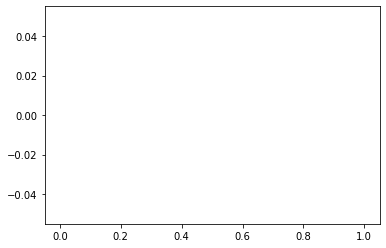

In [15]:
#trades2[trades2['Type']=='fbProphet']
#trades2.Type.unique()
#

plt.hist(trades2[trades2['Type']=='fbProphet+strategy']['expRet'], bins='auto')  # arguments are passed to np.histogram

In [16]:


set = pd.DataFrame()
for i in range(0,len(trades2)):
    value = pd.DataFrame(data.loc[pd.to_datetime(trades2.iloc[i]['Date'], errors='coerce').date()]).transpose().reset_index(drop=True)
    #value = pd.DataFrame(data.loc[trades2.iloc[i]['Date']]).transpose().reset_index(drop=True)
    value['index'] = i
    value['type'] = trades2.iloc[i]['Type']
    value['Date'] = trades2.iloc[i]['Date']
    value['ExpectedReturn'] = [trades2.iloc[i]['expRet']]
    value['sdev'] = trades2.iloc[i]['sdev']
    set = pd.concat([set,value.set_index('index')])




In [17]:

orderbook = pd.DataFrame()

#temp = pd.DataFrame([dateToBeSold,1],columns=['date','qty'])
column_names = ["date", "qty"]

sellDates = pd.DataFrame(columns = column_names)

#set[dateindex2[1].strftime('%Y-%m-%d')]
#need this becuase it's picking that extra date I set in yf.Download due to nyse having +1 day vs end_date in yf.Download
for i in pd.DataFrame(frequency).set_index(0)[end_date1:end_date].index[:-1]:
#for i in pd.DataFrame(frequency).set_index(0)[end_date1:end_date].index:
    
    idate = i.strftime('%Y-%m-%d')        
    
    #process purchases
    if (idate in set.set_index('Date').index):
        
        #innerSet = pd.DataFrame(set.set_index('Date').loc[idate]).transpose()
        innerSet = set.set_index('Date').loc[idate]
        
        #if isinstance(innerSet, pd.DataFrame):
            #print("pd")
        if isinstance(innerSet, pd.Series):
            #print("series")
            innerSet = pd.DataFrame(innerSet).transpose()

        #print(innerSet)
        types = innerSet.type.unique()
        #display(innerSet)

        for t in types:
            innerSet_t = innerSet[innerSet['type']==t]
            #print(innerSet[innerSet['type']==t])
            #print(innerSet_t)

            temp = pd.DataFrame()

            #estRet = set.set_index('Date').loc[idate]['ExpectedReturn']
            estRet = innerSet_t.loc[idate]['ExpectedReturn']

            temp['orderside'] = ['buy']        

            #if len(data[start_date:idate])-1+n_forward>=len(data[start_date:]):
                #dateToBesold = np.nan    
                #dateToBeSold = frequency[frequency.get_loc(idate)+n_forward].strftime('%Y-%m-%d')
                #frequency[pd.DataFrame(frequency).set_index('Date').index.get_loc(dateindex[i])+n_forward].strftime('%Y-%m-%d')
                #temp['valueAtSale'] = np.nan
            #else:

            if (innerSet_t['type'][0] == strategy) or (innerSet_t['type'][0] == 'fbProphet') or (innerSet_t['type'][0]=='fbProphet+strategy'):
                #dateToBeSold = data.iloc[len(data[start_date:idate])-1+n_forward].name.strftime('%Y-%m-%d') 
                dateToBeSold = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())+n_forward].strftime('%Y-%m-%d')
                #frequency[pd.DataFrame(frequency).set_index('Date').index.get_loc(dateindex[i])+n_forward].strftime('%Y-%m-%d')
            else:
                dateToBeSold = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())+1].strftime('%Y-%m-%d')

            #temp['valueAtSale'] = pd.DataFrame(data.iloc[len(data[start_date:idate])-1+n_forward]).transpose()['Close'].values[0]            
            if dateToBeSold in data.index:
                temp['valueAtSale'] = data.loc[datetime.datetime.strptime(dateToBeSold, "%Y-%m-%d").date()]['Close']
                #data.loc[dateToBeSold]['Close']
            else:
                temp['valueAtSale'] = np.nan

            #temp['valueAtSale'] = data.loc[dateToBeSold]['Close']

            temp['date'] = [idate]
            temp['valueAtPurchase'] = innerSet_t['Close'][0]
            temp['estRet'] = estRet
            temp['type'] = t
            #innerSet_t['type'][0]
            #temp['qty'] = Qty
            temp['dateBought'] = idate        
            temp['dateToBeSold'] = dateToBeSold

            btemp = pd.DataFrame(columns = column_names)
            btemp["date"]=[dateToBeSold]
            btemp["type"]=t
            #btemp["qty"]=[Qty]

            sellDates = sellDates.append(btemp,ignore_index=True)

            temp = temp.round(4)

            orderbook = orderbook.append(temp,ignore_index=True)
        
        

In [18]:
(orderbook[orderbook['type']=='SMA']['valueAtSale']>orderbook[orderbook['type']=='SMA']['valueAtPurchase']).agg("mean")

0.0

In [19]:
#data.loc[dateToBeSold]['Close'] 

In [20]:
#temp['valueAtPurchase'] = 
#data.loc[dateBought]['Close']
#data.loc['2018-12-10']
#dateBought
#data.index.get_loc(dateBought)
#type(dateBought)
#type(data.index[0])
#datetime.date(dateBought)


In [21]:

#for i in dateindex2:
for i in sellDates.sort_values(by=['date'], ascending=True)['date'].unique():
#sellDates.set_index('date').index:
    
    idate = i
    #.strftime('%Y-%m-%d')        
    
    #process sales
        
    #if (idate in sellDates.set_index('date').index): 

    dateTypes = sellDates.set_index('date').loc[idate]
    if isinstance(dateTypes, pd.Series):
        dateTypes = pd.DataFrame(dateTypes).transpose()

    types = dateTypes['type'].unique()

    for t in types:
        #print(t)
        if (t == strategy) or (t == 'fbProphet') or (t == 'fbProphet+strategy'):

            dateBought = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())-n_forward].strftime('%Y-%m-%d')
        else:
            dateBought = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())-1].strftime('%Y-%m-%d')

        innerSet = set.set_index('Date').loc[dateBought]

        if isinstance(innerSet, pd.Series):
            innerSet = pd.DataFrame(innerSet).transpose()

        innerSet_t = innerSet[innerSet['type']==t]   
        #print([innerSet_t['ExpectedReturn']])

        temp = pd.DataFrame()            

        dateToBeSold = idate
        temp['dateBought'] = [dateBought]
        if dateToBeSold in data.index:                        
            temp['valueAtSale'] = data.loc[datetime.datetime.strptime(dateToBeSold, "%Y-%m-%d").date()]['Close']
            #data.loc[dateToBeSold]['Close']                    
        else:
            temp['valueAtSale'] = np.nan

        temp['valueAtPurchase'] = data.iloc[data.index.get_loc(datetime.datetime.strptime(dateBought, "%Y-%m-%d").date())]['Close']
        #data.loc[dateBought]['Close']

        temp['estRet'] = [innerSet_t['ExpectedReturn'][0]]
        temp['valueAtSale'] = data.iloc[data.index.get_loc(datetime.datetime.strptime(dateToBeSold, "%Y-%m-%d").date())]['Close']

        temp['orderside'] = ['sell']   
        temp['type'] = [t]
        temp['date'] = [idate]
        #print(temp)

        temp = temp.round(4)

        orderbook = orderbook.append(temp,ignore_index=True)

        #counter=counter+1
        #print(counter)
        #print(idate)


In [22]:
(orderbook[orderbook['type']=='fbProphet']['valueAtSale']>orderbook[orderbook['type']=='fbProphet']['valueAtPurchase']).agg("mean")

nan

In [23]:
display(orderbook.sort_values(by=['date','orderside','type'], ascending=True))


orderside  valueAtSale        date  valueAtPurchase  estRet  type  \
0          buy          NaN  2018-12-13        3313.6772  1.1592     H   
1          buy          NaN  2018-12-13        3313.6772  0.4540   adf   
2          buy          NaN  2018-12-14        3242.4849  1.1591     H   
3          buy          NaN  2018-12-14        3242.4849  0.4550   adf   
2169      sell    3242.4849  2018-12-14        3313.6772  1.1592     H   
2170      sell    3242.4849  2018-12-14        3313.6772  0.4540   adf   
4          buy          NaN  2018-12-15        3236.7617  1.1590     H   
5          buy          NaN  2018-12-15        3236.7617  0.4547   adf   
2171      sell    3236.7617  2018-12-15        3242.4849  1.1591     H   
2172      sell    3236.7617  2018-12-15        3242.4849  0.4550   adf   
6          buy          NaN  2018-12-16        3252.8391  1.1590     H   
7          buy          NaN  2018-12-16        3252.8391  0.4540   adf   
2173      sell    3252.8391  2018-12-16        3236.7617  1.1590     H   
2174      sell    3252.8391  2018-12-16        3236.7617  0.4547   adf   
8          buy          NaN  2018-12-17        3545.8647  1.1584     H   
9          buy          NaN  2018-12-17        3545.8647  0.4465   adf   
2175      sell    3545.8647  2018-12-17        3252.8391  1.1590     H   
2176      sell    3545.8647  2018-12-17        3252.8391  0.4540   adf   
10         buy          NaN  2018-12-18        3696.0591  1.1588     H   
11         buy          NaN  2018-12-18        3696.0591  0.4432   adf   
2177      sell    3696.0591  2018-12-18        3545.8647  1.1584     H   
2178      sell    3696.0591  2018-12-18        3545.8647  0.4465   adf   
12         buy          NaN  2018-12-19        3745.9507  1.1587     H   
13         buy          NaN  2018-12-19        3745.9507  0.4420   adf   
2179      sell    3745.9507  2018-12-19        3696.0591  1.1588     H   
2180      sell    3745.9507  2018-12-19        3696.0591  0.4432   adf   
14         buy          NaN  2018-12-20        4134.4414  1.1583     H   
15         buy          NaN  2018-12-20        4134.4414  0.4347   adf   
2181      sell    4134.4414  2018-12-20        3745.9507  1.1587     H   
2182      sell    4134.4414  2018-12-20        3745.9507  0.4420   adf   
16         buy          NaN  2018-12-21        3896.5437  1.1581     H   
17         buy          NaN  2018-12-21        3896.5437  0.4390   adf   
2183      sell    3896.5437  2018-12-21        4134.4414  1.1583     H   
2184      sell    3896.5437  2018-12-21        4134.4414  0.4347   adf   
18         buy          NaN  2018-12-22        4014.1826  1.1580     H   
19         buy          NaN  2018-12-22        4014.1826  0.4364   adf   
2185      sell    4014.1826  2018-12-22        3896.5437  1.1581     H   
2186      sell    4014.1826  2018-12-22        3896.5437  0.4390   adf   
20         buy          NaN  2018-12-23        3998.9802  1.1579     H   
21         buy          NaN  2018-12-23        3998.9802  0.4364   adf   
2187      sell    3998.9802  2018-12-23        4014.1826  1.1580     H   
2188      sell    3998.9802  2018-12-23        4014.1826  0.4364   adf   
22         buy          NaN  2018-12-24        4078.5991  1.1588     H   
23         buy          NaN  2018-12-24        4078.5991  0.4347   adf   
2189      sell    4078.5991  2018-12-24        3998.9802  1.1579     H   
2190      sell    4078.5991  2018-12-24        3998.9802  0.4364   adf   
24         buy          NaN  2018-12-25        3815.4907  1.1585     H   
25         buy          NaN  2018-12-25        3815.4907  0.4387   adf   
2191      sell    3815.4907  2018-12-25        4078.5991  1.1588     H   
2192      sell    3815.4907  2018-12-25        4078.5991  0.4347   adf   
26         buy          NaN  2018-12-26        3857.2976  1.1585     H   
27         buy          NaN  2018-12-26        3857.2976  0.4373   adf   
2193      sell    3857.2976  2018-12-26        3815.4907  1.1585     H   
2194     

In [24]:
orderbook[(orderbook['type']=='MACD')]

orderside  valueAtSale        date  valueAtPurchase  estRet  type  \
158        buy          NaN  2019-03-02        3864.4150  0.0001  MACD   
161        buy          NaN  2019-03-03        3847.1758  0.0010  MACD   
164        buy          NaN  2019-03-04        3761.5571  0.0014  MACD   
167        buy          NaN  2019-03-05        3896.3750  0.0020  MACD   
170        buy          NaN  2019-03-06        3903.9426  0.0026  MACD   
173        buy          NaN  2019-03-07        3911.4844  0.0032  MACD   
176        buy          NaN  2019-03-08        3901.1316  0.0038  MACD   
179        buy          NaN  2019-03-09        3963.3137  0.0045  MACD   
182        buy          NaN  2019-03-10        3951.5999  0.0052  MACD   
185        buy          NaN  2019-03-11        3905.2273  0.0058  MACD   
188        buy          NaN  2019-03-12        3909.1562  0.0063  MACD   
191        buy          NaN  2019-03-13        3906.7173  0.0067  MACD   
194        buy          NaN  2019-03-14        3924.3691  0.0071  MACD   
197        buy          NaN  2019-03-15        3960.9111  0.0075  MACD   
200        buy          NaN  2019-03-16        4048.7258  0.0080  MACD   
203        buy          NaN  2019-03-17        4025.2290  0.0087  MACD   
206        buy          NaN  2019-03-18        4032.5073  0.0093  MACD   
209        buy          NaN  2019-03-19        4071.1902  0.0101  MACD   
212        buy          NaN  2019-03-20        4087.4763  0.0109  MACD   
215        buy          NaN  2019-03-21        4029.3269  0.0117  MACD   
218        buy          NaN  2019-03-22        4023.9683  0.0123  MACD   
221        buy          NaN  2019-03-23        4035.8264  0.0128  MACD   
224        buy          NaN  2019-03-24        4022.1682  0.0133  MACD   
227        buy          NaN  2019-03-25        3963.0706  0.0135  MACD   
230        buy          NaN  2019-03-26        3985.0808  0.0136  MACD   
233        buy          NaN  2019-03-27        4087.0662  0.0138  MACD   
236        buy          NaN  2019-03-28        4069.1072  0.0141  MACD   
239        buy          NaN  2019-03-29        4098.3745  0.0145  MACD   
242        buy          NaN  2019-03-30        4106.6602  0.0148  MACD   
245        buy          NaN  2019-03-31        4105.4043  0.0152  MACD   
248        buy          NaN  2019-04-01        4158.1831  0.0157  MACD   
251        buy          NaN  2019-04-02        4879.8779  0.0194  MACD   
254        buy          NaN  2019-04-03        4973.0220  0.0246  MACD   
257        buy          NaN  2019-04-04        4922.7988  0.0299  MACD   
260        buy          NaN  2019-04-05        5036.6812  0.0349  MACD   
263        buy          NaN  2019-04-06        5059.8174  0.0395  MACD   
266        buy          NaN  2019-04-07        5198.8970  0.0438  MACD   
269        buy          NaN  2019-04-08        5289.7710  0.0478  MACD   
272        buy          NaN  2019-04-09        5204.9585  0.0512  MACD   
275        buy          NaN  2019-04-10        5324.5518  0.0542  MACD   
278        buy          NaN  2019-04-11        5064.4878  0.0564  MACD   
281        buy          NaN  2019-04-12        5089.5391  0.0579  MACD   
284        buy          NaN  2019-04-13        5096.5864  0.0590  MACD   
287        buy          NaN  2019-04-14        5167.7222  0.0598  MACD   
290        buy          NaN  2019-04-15        5067.1084  0.0603  MACD   
293        buy          NaN  2019-04-16        5235.5596  0.0608  MACD   
296        buy          NaN  2019-04-17        5251.9380  0.0613  MACD   
299        buy          NaN  2019-04-18        5298.3857  0.0619  MACD   
302        buy          NaN  2019-04-19        5303.8125  0.0626  MACD   
305        buy          NaN  2019-04-20        5337.8862  0.0633  MACD   
308        buy          NaN  2019-04-21        5314.5312  0.0640  MACD   
311        buy          NaN  2019-04-22        5399.3652  0.0649  MACD   
314        buy          NaN  2019-04-23        5572.3623  0.0661  MACD   
317      

(array([10.,  6.,  4., 16., 42., 12., 22., 92., 28.]),
 array([0.0059    , 0.00901111, 0.01212222, 0.01523333, 0.01834444,
        0.02145556, 0.02456667, 0.02767778, 0.03078889, 0.0339    ]),
 <a list of 9 Patch objects>)

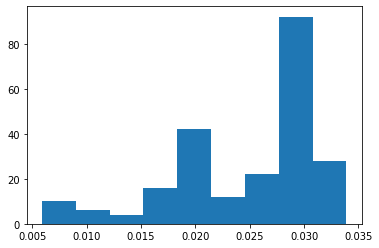

In [25]:

#filtered_orderbook = orderbook[(orderbook['type']=='fbProphet+strategy')]
#filtered_orderbook = orderbook[(orderbook['type']=='fbProphet')]
filtered_orderbook = orderbook[(orderbook['type']==strategy)]
#filtered_orderbook = orderbook[(orderbook['type']=='MACD') & (orderbook['estRet']>=.04) | (orderbook['type']=='fbProphet') | (orderbook['type']==strategy)]
#filtered_orderbook = orderbook[(orderbook['type']=='fbProphet') | (orderbook['type']==strategy)]
#filtered_orderbook = orderbook[(orderbook['type']=='MACD') & (orderbook['estRet']>=.04)]

#filtered_orderbook = orderbook[((orderbook['type']=='MACD') & (orderbook['estRet']>=.04) )| ((orderbook['type']=='fbProphet') | (orderbook['type']==strategy) |((orderbook['type']=='H') & (orderbook['estRet']>=1) )|( (orderbook['type']=='adf') & (orderbook['estRet']>=.9)) )]
#filtered_orderbook = filtered_orderbook.sort_values(by=['date','orderside','type'], ascending=True)
#display(filtered_orderbook.sort_values(by=['date','orderside','type'], ascending=True))
#display(filtered_orderbook)

plt.hist(filtered_orderbook['estRet'].dropna(), bins='auto')  # arguments are passed to np.histogram
#plt.hist(orderbook[orderbook['type']=='adf']['estRet'].dropna(), bins='auto')  # arguments are passed to np.histogram

In [26]:
filtered_orderbook

orderside  valueAtSale        date  valueAtPurchase  estRet type  \
813        buy          NaN  2019-10-23        7514.6719  0.0293  SMA   
818        buy          NaN  2019-10-25        8660.7002  0.0286  SMA   
821        buy          NaN  2019-10-26        9244.9727  0.0287  SMA   
824        buy          NaN  2019-10-27        9551.7148  0.0292  SMA   
827        buy          NaN  2019-10-28        9256.1484  0.0292  SMA   
830        buy          NaN  2019-10-29        9427.6875  0.0291  SMA   
833        buy          NaN  2019-10-30        9205.7266  0.0291  SMA   
836        buy          NaN  2019-10-31        9199.5850  0.0291  SMA   
839        buy          NaN  2019-11-01        9261.1045  0.0289  SMA   
842        buy          NaN  2019-11-02        9324.7178  0.0287  SMA   
845        buy          NaN  2019-11-03        9235.3545  0.0286  SMA   
848        buy          NaN  2019-11-04        9412.6123  0.0285  SMA   
851        buy          NaN  2019-11-05        9342.5273  0.0281  SMA   
854        buy          NaN  2019-11-06        9360.8799  0.0279  SMA   
857        buy          NaN  2019-11-07        9267.5615  0.0278  SMA   
860        buy          NaN  2019-11-08        8804.8809  0.0276  SMA   
937        buy          NaN  2019-12-16        6932.4805  0.0223  SMA   
940        buy          NaN  2019-12-17        6640.5151  0.0236  SMA   
943        buy          NaN  2019-12-18        7276.8027  0.0231  SMA   
946        buy          NaN  2019-12-19        7202.8442  0.0222  SMA   
949        buy          NaN  2019-12-20        7218.8164  0.0218  SMA   
954        buy          NaN  2019-12-22        7511.5889  0.0193  SMA   
957        buy          NaN  2019-12-23        7355.6284  0.0198  SMA   
960        buy          NaN  2019-12-24        7322.5322  0.0208  SMA   
963        buy          NaN  2019-12-25        7275.1558  0.0204  SMA   
966        buy          NaN  2019-12-26        7238.9668  0.0187  SMA   
969        buy          NaN  2019-12-27        7290.0884  0.0188  SMA   
972        buy          NaN  2019-12-28        7317.9902  0.0188  SMA   
975        buy          NaN  2019-12-29        7422.6528  0.0190  SMA   
978        buy          NaN  2019-12-30        7292.9951  0.0191  SMA   
987        buy          NaN  2020-01-03        7344.8843  0.0198  SMA   
994        buy          NaN  2020-01-06        7769.2192  0.0193  SMA   
997        buy          NaN  2020-01-07        8163.6924  0.0195  SMA   
1000       buy          NaN  2020-01-08        8079.8628  0.0191  SMA   
1003       buy          NaN  2020-01-09        7879.0713  0.0173  SMA   
1006       buy          NaN  2020-01-10        8166.5542  0.0178  SMA   
1009       buy          NaN  2020-01-11        8037.5376  0.0183  SMA   
1012       buy          NaN  2020-01-12        8192.4941  0.0185  SMA   
1015       buy          NaN  2020-01-13        8144.1943  0.0188  SMA   
1018       buy          NaN  2020-01-14        8827.7646  0.0194  SMA   
1021       buy          NaN  2020-01-15        8807.0107  0.0196  SMA   
1025       buy          NaN  2020-01-16        8723.7861  0.0196  SMA   
1029       buy          NaN  2020-01-17        8929.0381  0.0208  SMA   
1033       buy          NaN  2020-01-18        8942.8086  0.0207  SMA   
1037       buy          NaN  2020-01-19        8706.2451  0.0204  SMA   
1062       buy          NaN  2020-01-27        8909.8193  0.0169  SMA   
1066       buy          NaN  2020-01-28        9358.5898  0.0165  SMA   
1070       buy          NaN  2020-01-29        9316.6299  0.0163  SMA   
1074       buy          NaN  2020-01-30        9508.9932  0.0163  SMA   
1078       buy          NaN  2020-01-31        9350.5293  0.0156  SMA   
1085       buy          NaN  2020-02-02        9344.3652  0.0142  SMA   
1089       buy          NaN  2020-02-03        9293.5215  0.0132  SMA   
1265       buy          NaN  2020-04-29        8801.0381  0.0059  SMA   
1268       buy          NaN  2020-04-30        8658.5537  0.007

In [27]:
len(filtered_orderbook)

232

In [28]:
print(len(filtered_orderbook.sort_values(by=['date','orderside','type'], ascending=True)))
filtered_orderbook.sort_values(by=['date','orderside','type'], ascending=True)

232


orderside  valueAtSale        date  valueAtPurchase  estRet type  \
813        buy          NaN  2019-10-23        7514.6719  0.0293  SMA   
818        buy          NaN  2019-10-25        8660.7002  0.0286  SMA   
821        buy          NaN  2019-10-26        9244.9727  0.0287  SMA   
824        buy          NaN  2019-10-27        9551.7148  0.0292  SMA   
827        buy          NaN  2019-10-28        9256.1484  0.0292  SMA   
830        buy          NaN  2019-10-29        9427.6875  0.0291  SMA   
833        buy          NaN  2019-10-30        9205.7266  0.0291  SMA   
2992      sell    9205.7266  2019-10-30        7514.6719  0.0293  SMA   
836        buy          NaN  2019-10-31        9199.5850  0.0291  SMA   
839        buy          NaN  2019-11-01        9261.1045  0.0289  SMA   
2997      sell    9261.1045  2019-11-01        8660.7002  0.0286  SMA   
842        buy          NaN  2019-11-02        9324.7178  0.0287  SMA   
3000      sell    9324.7178  2019-11-02        9244.9727  0.0287  SMA   
845        buy          NaN  2019-11-03        9235.3545  0.0286  SMA   
3003      sell    9235.3545  2019-11-03        9551.7148  0.0292  SMA   
848        buy          NaN  2019-11-04        9412.6123  0.0285  SMA   
3006      sell    9412.6123  2019-11-04        9256.1484  0.0292  SMA   
851        buy          NaN  2019-11-05        9342.5273  0.0281  SMA   
3009      sell    9342.5273  2019-11-05        9427.6875  0.0291  SMA   
854        buy          NaN  2019-11-06        9360.8799  0.0279  SMA   
3012      sell    9360.8799  2019-11-06        9205.7266  0.0291  SMA   
857        buy          NaN  2019-11-07        9267.5615  0.0278  SMA   
3015      sell    9267.5615  2019-11-07        9199.5850  0.0291  SMA   
860        buy          NaN  2019-11-08        8804.8809  0.0276  SMA   
3018      sell    8804.8809  2019-11-08        9261.1045  0.0289  SMA   
3021      sell    8813.5820  2019-11-09        9324.7178  0.0287  SMA   
3024      sell    9055.5264  2019-11-10        9235.3545  0.0286  SMA   
3027      sell    8757.7881  2019-11-11        9412.6123  0.0285  SMA   
3030      sell    8815.6621  2019-11-12        9342.5273  0.0281  SMA   
3033      sell    8808.2627  2019-11-13        9360.8799  0.0279  SMA   
3036      sell    8708.0947  2019-11-14        9267.5615  0.0278  SMA   
3039      sell    8491.9922  2019-11-15        8804.8809  0.0276  SMA   
937        buy          NaN  2019-12-16        6932.4805  0.0223  SMA   
940        buy          NaN  2019-12-17        6640.5151  0.0236  SMA   
943        buy          NaN  2019-12-18        7276.8027  0.0231  SMA   
946        buy          NaN  2019-12-19        7202.8442  0.0222  SMA   
949        buy          NaN  2019-12-20        7218.8164  0.0218  SMA   
954        buy          NaN  2019-12-22        7511.5889  0.0193  SMA   
957        buy          NaN  2019-12-23        7355.6284  0.0198  SMA   
3116      sell    7355.6284  2019-12-23        6932.4805  0.0223  SMA   
960        buy          NaN  2019-12-24        7322.5322  0.0208  SMA   
3119      sell    7322.5322  2019-12-24        6640.5151  0.0236  SMA   
963        buy          NaN  2019-12-25        7275.1558  0.0204  SMA   
3122      sell    7275.1558  2019-12-25        7276.8027  0.0231  SMA   
966        buy          NaN  2019-12-26        7238.9668  0.0187  SMA   
3125      sell    7238.9668  2019-12-26        7202.8442  0.0222  SMA   
969        buy          NaN  2019-12-27        7290.0884  0.0188  SMA   
3128      sell    7290.0884  2019-12-27        7218.8164  0.0218  SMA   
972        buy          NaN  2019-12-28        7317.9902  0.0188  SMA   
975        buy          NaN  2019-12-29        7422.6528  0.0190  SMA   
3133      sell    7422.6528  2019-12-29        7511.5889  0.0193  SMA   
978        buy          NaN  2019-12-30        7292.9951  0.0191  SMA   
3136      sell    7292.9951  2019-12-30        7355.6284  0.0198  SMA   
3139      sell    7193.5991  2019-12-31        7322.5322  0.020

In [29]:

funds = 1000
BuyFundsPercent = 1
percentHeldOnSell = 1

buyLog = pd.DataFrame()
sellLog = pd.DataFrame()
runningLog = pd.DataFrame()

held = 0
upper = 0
lower = 0

#weights = [3,2,1]

#weights2 = 1/np.array(weights)/sum(1/np.array(weights))

weights2 = [.125, .25, .75, .75]

for i in pd.DataFrame(frequency).set_index(0)[end_date1:end_date].index[:-1]:
#for i in pd.DataFrame(frequency).set_index(0)[end_date1:end_date].index:
    
    
    temp = pd.DataFrame()
    rtemp = pd.DataFrame()
    _temp = pd.DataFrame()
    
    t = i.strftime('%Y-%m-%d')
    
    subset = filtered_orderbook[filtered_orderbook['date']==t]
        
    gain = 0
    paid = 0

    if len(subset) != 0:
        print()
        print("date " + str(i))
        print(subset)
        
        sales = subset[subset['orderside'] == 'sell']        
        types_s = sales['type'].unique()
        
        for ts_ in types_s:
            
            sales_t = sales[sales['type']==ts_]

            if len(sales_t) != 0:                        

                oldvalue = sales_t['valueAtPurchase'].values[0]

                newvalue = sales_t['valueAtSale'].values[0]      
                
                bl = buyLog.set_index('date').loc[datetime.datetime.strptime(sales_t['dateBought'].values[0], "%Y-%m-%d").date()]
                #buyLog.set_index('date').loc[sales_t['dateBought'].values[0]]
                
                if isinstance(bl, pd.Series):
                    bl = pd.DataFrame(bl).transpose()
                
                Qty = bl[bl['type']==ts_]['qty'][0]
                    
                gain = gain + (newvalue * Qty)

                _temp['date'] = [i]
                _temp['type'] = [ts_]
                _temp['qty'] = [Qty]
                
                sellLog = pd.concat([sellLog,_temp])                
    
        purchases = subset[subset['orderside'] == 'buy']
        
        types_p = purchases['type'].unique()
        
        for tp in types_p:
            
            purchases_t = purchases[purchases['type']==tp]

            if len(purchases_t) != 0:
                
                weights = [3,2,1]                

                #print(tp)
                if tp == 'adf': BuyFundsPercent_ = BuyFundsPercent * weights2[0]
                if tp == 'H': BuyFundsPercent_ = BuyFundsPercent * weights2[0]
                if tp == 'MACD': BuyFundsPercent_ = BuyFundsPercent * weights2[1]                
                if tp == strategy: BuyFundsPercent_ = BuyFundsPercent * weights2[2]
                if tp == 'fbProphet': BuyFundsPercent_ = BuyFundsPercent * weights2[3]   
                if tp == 'fbProphet+strategy': BuyFundsPercent_ = BuyFundsPercent * weights2[3]   
                
                ProportionOfFunds = funds * BuyFundsPercent_

                Qty = ProportionOfFunds / purchases_t['valueAtPurchase'].values[0]
                Qty = Qty.round(6)
                #print(purchases['valueAtPurchase'].values[0])
                #print("Qty purchased " + str(Qty.round(2)))

                temp['date'] = [i]
                temp['type'] = [tp]
                temp['qty'] = [Qty]

                paid = purchases_t['valueAtPurchase'].values[0]*Qty
                
                print("buy")
                print(temp)

                buyLog = pd.concat([buyLog,temp])

                #print(buyLog)
                
                funds = funds - paid           

        funds = funds + gain
        
        rtemp['date'] =  [i]
        rtemp['funds'] =  [funds]
        
        if len(sellLog) != 0:
            remainder = (sum(buyLog['qty'])-sum(sellLog['qty']))            
            
        else:
            remainder = (sum(buyLog['qty']))
        
        rtemp['held'] = format(remainder,".6f")
        
        #print(remainder)
        rtemp['value'] = remainder * data.loc[i]['Close']
        rtemp['portValue'] = funds + remainder * data.loc[i]['Close']
        #print(rtemp)
                
        #print("in " + str(gain))
        #print("out " + str(paid))
        #print("held: " + str(remainder))
        #print("Close Value: " + str(data.loc[i]['Close']))
        #print("held Value: " + str(remainder * data.loc[i]['Close']))
        #print("funds " + str(funds))
        #print("portValue " + str(funds + remainder * data.loc[i]['Close']))
        #print()
            
        runningLog = runningLog.append(rtemp)
        
funds = 1000                                                    
                


date 2019-10-23
    orderside  valueAtSale        date  valueAtPurchase  estRet type  \
813       buy          NaN  2019-10-23        7514.6719  0.0293  SMA   

     dateBought dateToBeSold  
813  2019-10-23   2019-10-30  
buy
         date type       qty
0  2019-10-23  SMA  0.099805

date 2019-10-25
    orderside  valueAtSale        date  valueAtPurchase  estRet type  \
818       buy          NaN  2019-10-25        8660.7002  0.0286  SMA   

     dateBought dateToBeSold  
818  2019-10-25   2019-11-01  
buy
         date type       qty
0  2019-10-25  SMA  0.021649

date 2019-10-26
    orderside  valueAtSale        date  valueAtPurchase  estRet type  \
821       buy          NaN  2019-10-26        9244.9727  0.0287  SMA   

     dateBought dateToBeSold  
821  2019-10-26   2019-11-02  
buy
         date type       qty
0  2019-10-26  SMA  0.005071

date 2019-10-27
    orderside  valueAtSale        date  valueAtPurchase  estRet type  \
824       buy          NaN  2019-10-27        9551.71

In [30]:
sellDates

date  qty  type
0     2018-12-14  NaN     H
1     2018-12-14  NaN   adf
2     2018-12-15  NaN     H
3     2018-12-15  NaN   adf
4     2018-12-16  NaN     H
5     2018-12-16  NaN   adf
6     2018-12-17  NaN     H
7     2018-12-17  NaN   adf
8     2018-12-18  NaN     H
9     2018-12-18  NaN   adf
10    2018-12-19  NaN     H
11    2018-12-19  NaN   adf
12    2018-12-20  NaN     H
13    2018-12-20  NaN   adf
14    2018-12-21  NaN     H
15    2018-12-21  NaN   adf
16    2018-12-22  NaN     H
17    2018-12-22  NaN   adf
18    2018-12-23  NaN     H
19    2018-12-23  NaN   adf
20    2018-12-24  NaN     H
21    2018-12-24  NaN   adf
22    2018-12-25  NaN     H
23    2018-12-25  NaN   adf
24    2018-12-26  NaN     H
25    2018-12-26  NaN   adf
26    2018-12-27  NaN     H
27    2018-12-27  NaN   adf
28    2018-12-28  NaN     H
29    2018-12-28  NaN   adf
30    2018-12-29  NaN     H
31    2018-12-29  NaN   adf
32    2018-12-30  NaN     H
33    2018-12-30  NaN   adf
34    2018-12-31  NaN     H
35    2018-12-31  NaN   adf
36    2019-01-01  NaN     H
37    2019-01-01  NaN   adf
38    2019-01-02  NaN     H
39    2019-01-02  NaN   adf
40    2019-01-03  NaN     H
41    2019-01-03  NaN   adf
42    2019-01-04  NaN     H
43    2019-01-04  NaN   adf
44    2019-01-05  NaN     H
45    2019-01-05  NaN   adf
46    2019-01-06  NaN     H
47    2019-01-06  NaN   adf
48    2019-01-07  NaN     H
49    2019-01-07  NaN   adf
50    2019-01-08  NaN     H
51    2019-01-08  NaN   adf
52    2019-01-09  NaN     H
53    2019-01-09  NaN   adf
54    2019-01-10  NaN     H
55    2019-01-10  NaN   adf
56    2019-01-11  NaN     H
57    2019-01-11  NaN   adf
58    2019-01-12  NaN     H
59    2019-01-12  NaN   adf
60    2019-01-13  NaN     H
61    2019-01-13  NaN   adf
62    2019-01-14  NaN     H
63    2019-01-14  NaN   adf
64    2019-01-15  NaN     H
65    2019-01-15  NaN   adf
66    2019-01-16  NaN     H
67    2019-01-16  NaN   adf
68    2019-01-17  NaN     H
69    2019-01-17  NaN   adf
70    2019-01-18  NaN     H
71    2019-01-18  NaN   adf
72    2019-01-19  NaN     H
73    2019-01-19  NaN   adf
74    2019-01-20  NaN     H
75    2019-01-20  NaN   adf
76    2019-01-21  NaN     H
77    2019-01-21  NaN   adf
78    2019-01-22  NaN     H
79    2019-01-22  NaN   adf
80    2019-01-23  NaN     H
81    2019-01-23  NaN   adf
82    2019-01-24  NaN     H
83    2019-01-24  NaN   adf
84    2019-01-25  NaN     H
85    2019-01-25  NaN   adf
86    2019-01-26  NaN     H
87    2019-01-26  NaN   adf
88    2019-01-27  NaN     H
89    2019-01-27  NaN   adf
90    2019-01-28  NaN     H
91    2019-01-28  NaN   adf
92    2019-01-29  NaN     H
93    2019-01-29  NaN   adf
94    2019-01-30  NaN     H
95    2019-01-30  NaN   adf
96    2019-01-31  NaN     H
97    2019-01-31  NaN   adf
98    2019-02-01  NaN     H
99    2019-02-01  NaN   adf
100   2019-02-02  NaN     H
101   2019-02-02  NaN   adf
102   2019-02-03  NaN     H
103   2019-02-03  NaN   adf
104   2019-02-04  NaN     H
105   2019-02-04  NaN   adf
106   2019-02-05  NaN     H
107   2019-02-05  NaN   adf
108   2019-02-06  NaN     H
109   2019-02-06  NaN   adf
110   2019-02-07  NaN     H
111   2019-02-07  NaN   adf
112   2019-02-08  NaN     H
113   2019-02-08  NaN   adf
114   2019-02-09  NaN     H
115   2019-02-09  NaN   adf
116   2019-02-10  NaN     H
117   2019-02-10  NaN   adf
118   2019-02-11  NaN     H
119   2019-02-11  NaN   adf
120   2019-02-12  NaN     H
121   2019-02-12  NaN   adf
122   2019-02-13  NaN     H
123   2019-02-13  NaN   adf
124   2019-02-14  NaN     H
125   2019-02-14  NaN   adf
126   2019-02-15  NaN     H
127   2019-02-15  NaN   adf
128   2019-02-16  NaN     H
129   2019-02-16  NaN   adf
130   2019-02-17  NaN     H
131   2019-02-17  NaN   adf
132   2019-02-18  NaN     H
133   2019-02-18  NaN   adf
134   2019-02-19  NaN     H
135   2019-02-19  NaN   adf
136   2019-02-20  NaN     H
137   2019-02-20  NaN   adf
138   2019-02-21  NaN     H
139   2019-02-21  NaN   adf
140   2019-02-22  NaN     H
141   2019-02-22  NaN   adf
142   20

In [31]:
#sellLog['orderSide'] = 'sale'
#sellLog['cumsum'] = cumsum(sellLog['qty'])
#buyLog['orderSide'] = 'buy'
#buyLog['cumsum'] = cumsum(buyLog['qty'])

In [32]:
len(orderbook[orderbook['orderside']=='buy'])-len(orderbook[orderbook['orderside']=='sell'])

0

In [33]:
runningLog

date        funds      held        value    portValue
0  2019-10-23   249.998171  0.099805   750.001826   999.999998
0  2019-10-25    62.502672  0.121454  1051.876682  1114.379354
0  2019-10-26    15.621416  0.126525  1169.720165  1185.341581
0  2019-10-27     3.901462  0.127752  1220.250675  1224.152136
0  2019-10-28     0.976519  0.128068  1185.416418  1186.392937
0  2019-10-29     0.241159  0.128146  1208.120442  1208.361602
0  2019-10-30   918.834588  0.028361   261.083611  1179.918199
0  2019-10-31   229.712075  0.103269   950.031939  1179.744014
0  2019-11-01   257.921399  0.100223   928.175676  1186.097075
0  2019-11-02   111.765772  0.115897  1080.706816  1192.472588
0  2019-11-03    39.277475  0.123746  1142.838177  1182.115652
0  2019-11-04    12.790384  0.126560  1191.260213  1204.050597
0  2019-11-05     3.924325  0.127509  1191.256319  1195.180645
0  2019-11-06     1.172227  0.127803  1196.348532  1197.520758
0  2019-11-07   694.506305  0.052990   491.088085  1185.594390
0  2019-11-08   337.424360  0.093545   823.652580  1161.076940
0  2019-11-09   520.262119  0.072800   641.628772  1161.890891
0  2019-11-10   602.450077  0.063724   577.054362  1179.504439
0  2019-11-11   629.861953  0.060594   530.669411  1160.531365
0  2019-11-12   638.915638  0.059567   525.122545  1164.038183
0  2019-11-13   641.681433  0.059253   521.915989  1163.597422
0  2019-11-14   642.508702  0.059158   515.153468  1157.662170
0  2019-11-15  1144.877976  0.000000     0.000000  1144.877976
0  2019-12-16   286.220942  0.123860   858.657031  1144.877972
0  2019-12-17    71.553010  0.156187  1037.162138  1108.715148
0  2019-12-18    17.886590  0.163562  1190.208409  1208.094999
0  2019-12-19     4.474894  0.165424  1191.523305  1195.998199
0  2019-12-20     1.118145  0.165889  1197.522235  1198.640379
0  2019-12-22     0.276847  0.166001  1246.931264  1247.208110
0  2019-12-23   911.139023  0.042169   310.179495  1221.318517
0  2019-12-24   464.501171  0.103164   755.421715  1219.922886
0  2019-12-25   169.777334  0.143675  1045.258004  1215.035339
0  2019-12-26    55.922865  0.159403  1153.913024  1209.835889
0  2019-12-27    17.372877  0.164691  1200.611945  1217.984822
0  2019-12-28     4.346855  0.166471  1218.233152  1222.580007
0  2019-12-29     1.919647  0.166798  1238.083647  1240.003294
0  2019-12-30     0.687131  0.166967  1217.689516  1218.376647
0  2019-12-31   672.008186  0.073645   529.772607  1201.780793
0  2020-01-01  1016.795733  0.025759   185.469290  1202.265023
0  2020-01-02  1139.670154  0.008169    57.064306  1196.734460
0  2020-01-03   327.171707  0.118790   872.498803  1199.670511
0  2020-01-04   340.362676  0.117010   867.120945  1207.483621
0  2020-01-05   343.616245  0.116571   863.944679  1207.560923
0  2020-01-06    87.434011  0.149545  1161.847891  1249.281902
0  2020-01-07    21.855070  0.157578  1286.418318  1308.273388
0  2020-01-08     5.461028  0.159607  1289.602661  1295.063689
0  2020-01-09     1.363911  0.160127  1261.652048  1263.015959
0  2020-01-10   950.717670  0.043878   358.332065  1309.049735
0  2020-01-11   237.675560  0.132592  1065.713185  1303.388745
0  2020-01-12    59.415080  0.154351  1264.519663  1323.934744
0  2020-01-13   285.001118  0.126652  1031.478501  1316.479619
0  2020-01-14   142.167887  0.142832  1260.887280  1403.055167
0  2020-01-15    53.410833  0.152910  1346.680013  1400.090846
0  2020-01-16    17.887576  0.156982  1369.477395  1387.364971
0  2020-01-17     5.592291  0.158359  1413.993542  1419.585833
0  2020-01-18   794.750436  0.070114   627.016082  1421.766517
0  2020-01-19   388.125258  0.116819  1017.054848  1405.180107
0  2020-01-20   435.499879  0.111347   964.002528  1399.502407
0  2020-01-21   647.264222  0.087134   762.064774  1409.328996
0  2020-01-22   752.363588  0.075027   651.300082  1403.663670
0  2020-01-23   790.966308  0.070435   592.112928  1383.079236
0  2020-01-24   803.651350  0.068933   582.169141  1385.820492
0  2020-01-25   807.575871  0.068464   5

In [34]:
#new = sellLog.append(buyLog).sort_values(by=['date'], ascending=True)
#new[new['orderSide']=='sale']
#new

In [35]:
if end_date.strftime('%Y-%m-%d') != runningLog['date'].iloc[-1].strftime('%Y-%m-%d'):
    rl_temp = pd.DataFrame()
    rl_temp['date'] = [end_date]
    rl_temp['funds'] = [runningLog.iloc[-1]['funds']]
    rl_temp['held'] = [runningLog.iloc[-1]['held']]
    rl_temp['value'] = [runningLog.iloc[-1]['value']]
    rl_temp['portValue'] = [runningLog.iloc[-1]['portValue']]
    runningLog = runningLog.append(rl_temp)
    
    runningLog = runningLog.sort_values(by=['date'], ascending=True)
    
if end_date1.strftime('%Y-%m-%d') != runningLog['date'].iloc[0].strftime('%Y-%m-%d'):
    rl_temp = pd.DataFrame()
    rl_temp['date'] = [end_date1]
    rl_temp['funds'] = [funds]
    rl_temp['held'] = [0]
    rl_temp['value'] = [0]
    rl_temp['portValue'] = [funds]
    runningLog = runningLog.append(rl_temp)

    runningLog = runningLog.sort_values(by=['date'], ascending=True)


In [36]:
ret_data =  runningLog.set_index(pd.to_datetime(runningLog['date'], format='%Y-%m-%d'))['portValue'].pct_change()
#ret_data['date'] = pd.to_datetime(runningLog['date'], format='%Y-%m-%d')
ret_data

date
2018-12-13             NaN
2019-10-23   -2.495125e-09
2019-10-25    1.143794e-01
2019-10-26    6.367870e-02
2019-10-27    3.274209e-02
2019-10-28   -3.084519e-02
2019-10-29    1.851719e-02
2019-10-30   -2.353882e-02
2019-10-31   -1.476245e-04
2019-11-01    5.385118e-03
2019-11-02    5.375204e-03
2019-11-03   -8.685262e-03
2019-11-04    1.855567e-02
2019-11-05   -7.366761e-03
2019-11-06    1.957958e-03
2019-11-07   -9.959216e-03
2019-11-08   -2.067946e-02
2019-11-09    7.010306e-04
2019-11-10    1.515938e-02
2019-11-11   -1.608563e-02
2019-11-12    3.021735e-03
2019-11-13   -3.786481e-04
2019-11-14   -5.100778e-03
2019-11-15   -1.104311e-02
2019-12-16   -3.380819e-09
2019-12-17   -3.158662e-02
2019-12-18    8.963515e-02
2019-12-19   -1.001312e-02
2019-12-20    2.209184e-03
2019-12-22    4.051902e-02
2019-12-23   -2.075804e-02
2019-12-24   -1.142725e-03
2019-12-25   -4.006439e-03
2019-12-26   -4.279258e-03
2019-12-27    6.735569e-03
2019-12-28    3.772777e-03
2019-12-29    1.425125e

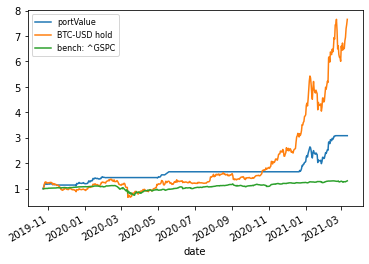

3.085439467782398


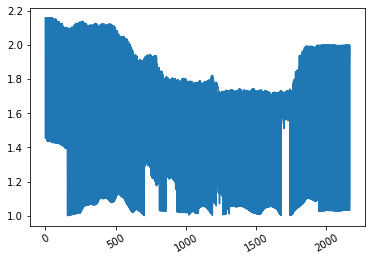

3.085439467782398
1.209306144525618


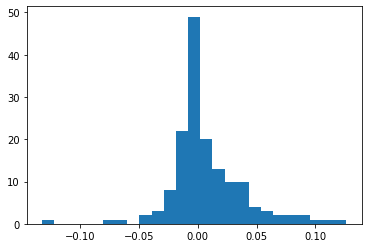

In [37]:

#ret_data =  runningLog.set_index('date')['portValue'].pct_change()
ret_data =  runningLog.set_index(pd.to_datetime(runningLog['date'], format='%Y-%m-%d'))['portValue'].pct_change()
cumulative_ret_data = (ret_data + 1).cumprod()

#data
ret_data2 = data[runningLog.set_index('date').index[1]:runningLog.set_index('date').index[-1]]['Close'].pct_change()
cum_ret_data2 = (ret_data2 + 1).cumprod()

#benchData
sp500_data = benchData[runningLog.set_index('date').index[1]:runningLog.set_index('date').index[-1]]['Close'].pct_change()
sp500_cumulative_ret_data = (sp500_data + 1).cumprod()

cumulative_ret_data.dropna().plot()

plt.plot(cum_ret_data2,label=name + " hold")
plt.plot(sp500_cumulative_ret_data,label="bench: " + benchName)
plt.legend(loc="upper left",fontsize=8)

plt.xticks(rotation=30) 

plt.show()

print(cumulative_ret_data[-1])

plt.plot((set['ExpectedReturn']+1))
plt.xticks(rotation=30) 
#len(set['ExpectedReturn']+1)

runningLog

plt.show()
print(cumulative_ret_data.iloc[-1])
plt.hist(runningLog.set_index('date')['portValue'].pct_change().dropna(), bins='auto')  # arguments are passed to np.histogram
print(runningLog['portValue'].dropna().pct_change().sum())

